## General information

This kernel is created using data of `Predicting Molecular Properties` competition.
We have information about atom couples in molecules and need to predict `scalar_coupling_constant` between these atoms.

![](http://www.et.byu.edu/~rowley/VLEfinal/methane_dimer.gif)

In this kernel I'll do EDA and will try some approaches to modelling.

*Work still in progress*


~Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful. I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils So if you see somewhere code like artgot_utils.function_name(parameters) - it is from this script~
I have realized that using utility scripts isn't very convenient, so I move all the code from that script into the notebook. But 

importing libraries

In [1]:
import os
import sys
sys.path.append("/root/champs/")

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt



# setting up altair
from utils import artgor_utils
workaround = artgor_utils.prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Data loading and overview

We have a lot of files, let's focus on the main ones for now.

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/sample_submission.csv')

In [3]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [4]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


So in out main data files we have information about moleculas and pairs of atoms
- test set in ~2 times smaller that train set;
- we have 28 unique atoms types and 8 coupling types;

In [5]:
np.isin(train['molecule_name'].unique(), (test['molecule_name'].unique())).sum()

0

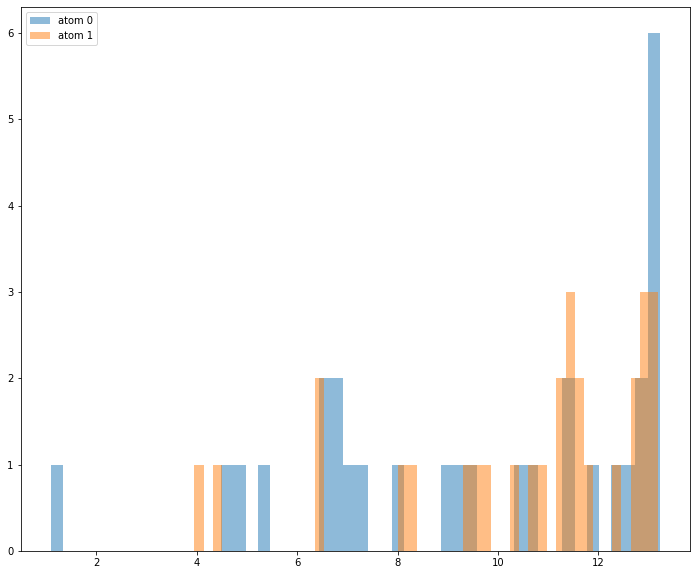

In [6]:
atom_0 = (train['atom_index_0'].value_counts()
    .reset_index()
    .rename(columns={'atom_index_0': 'count', 'index': 'atom_index_0'})
    .sort_values(by='count', ascending=False))['count']


atom_1 = (train['atom_index_1'].value_counts()
    .reset_index()
    .rename(columns={'atom_index_1': 'count', 'index': 'atom_index_1'})
    .sort_values(by='count', ascending=False))['count']

plt.figure(figsize=(12, 10))
_ = plt.hist(np.log(atom_0.values), label="atom 0", bins=50, alpha=0.5)
_ = plt.hist(np.log(atom_1.values), label="atom 1", bins=50, alpha=0.5)
plt.legend()

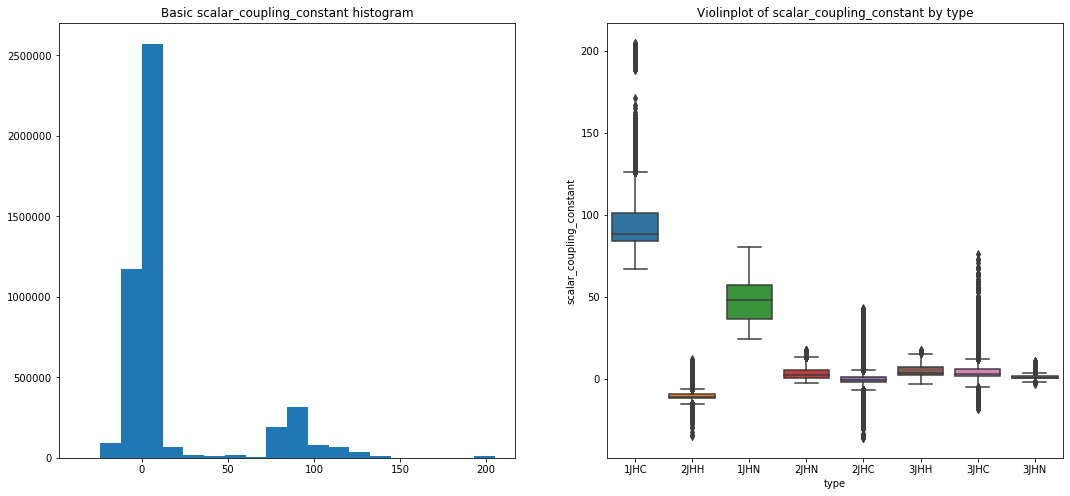

In [7]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.boxplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

In [8]:
train['type'].value_counts(normalize=True)

3JHC    0.324244597690884
2JHC    0.244877201170337
1JHC    0.152295751937412
3JHH    0.126790975037928
2JHH    0.081155875930923
3JHN    0.035725579291508
2JHN    0.025600952481749
1JHN    0.009309066459259
Name: type, dtype: float64

In [9]:
test['type'].value_counts(normalize=True)

3JHC    0.324081176847165
2JHC    0.244712720840441
1JHC    0.151906852888517
3JHH    0.126693146632545
2JHH    0.081070682511010
3JHN    0.036166226708632
2JHN    0.025712600307638
1JHN    0.009656593264052
Name: type, dtype: float64

There are many interesting things here:
- among first atoms there is a little number of atoms with index lower than 7 or higher than 24;
- among second atoms there is a little number of atoms with index higher than 24. Also index with atom with index 9 in quite rare;
- coupling types are unevenly distributed. There are 3 very popular, 3 quite rare and 2 with medium frequency;
- target variable has a bimodal distribution;
- different coupling types have really different values of target variable. Maybe it would make sense to build separate models for each of them;

## Plotting network graphs by type

We have molecules, atom pairs, so this means data, which is interconnected. Network graphs should be useful to visualize such data!

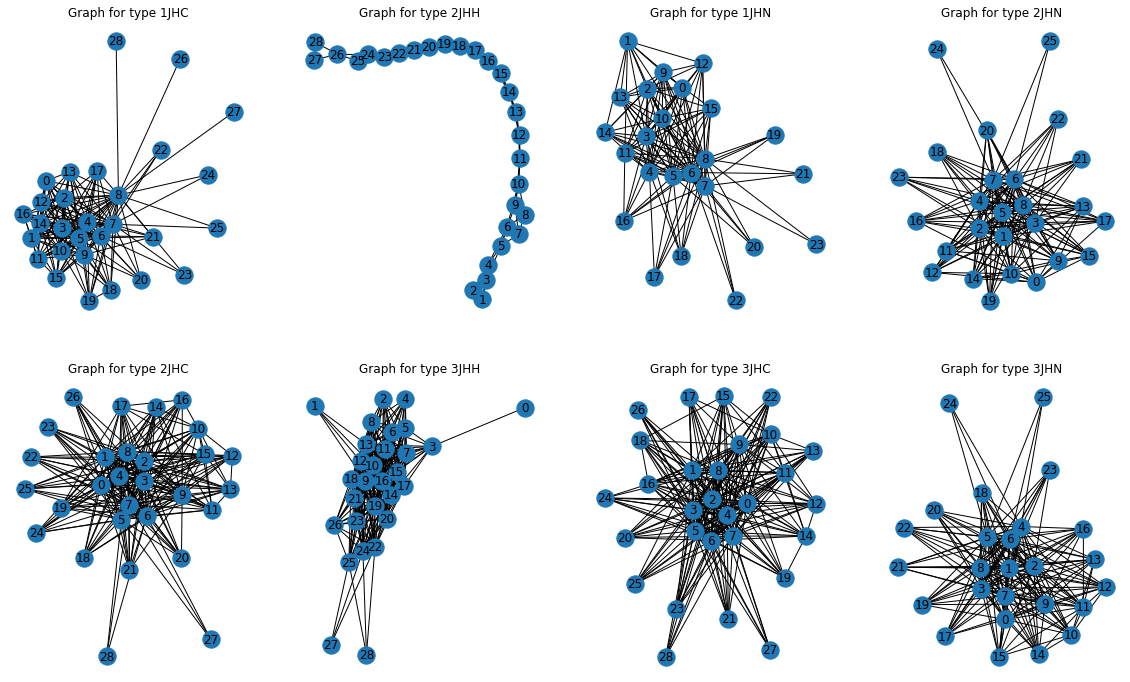

In [10]:
fig, ax = plt.subplots(figsize = (20, 12))

for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Cool! We can see that atom connections have different shapes for different types. Type 2JHH has an expecially unique scheme.
Also we can see that some atoms are connected only to several other atoms.

## Better network graphs
But there is a little problem: as we saw earlier, there are atoms which are very rare, as a result graphs will be skewed due to them. Now I'll drop atoms for each type which are present in less then 1% of connections

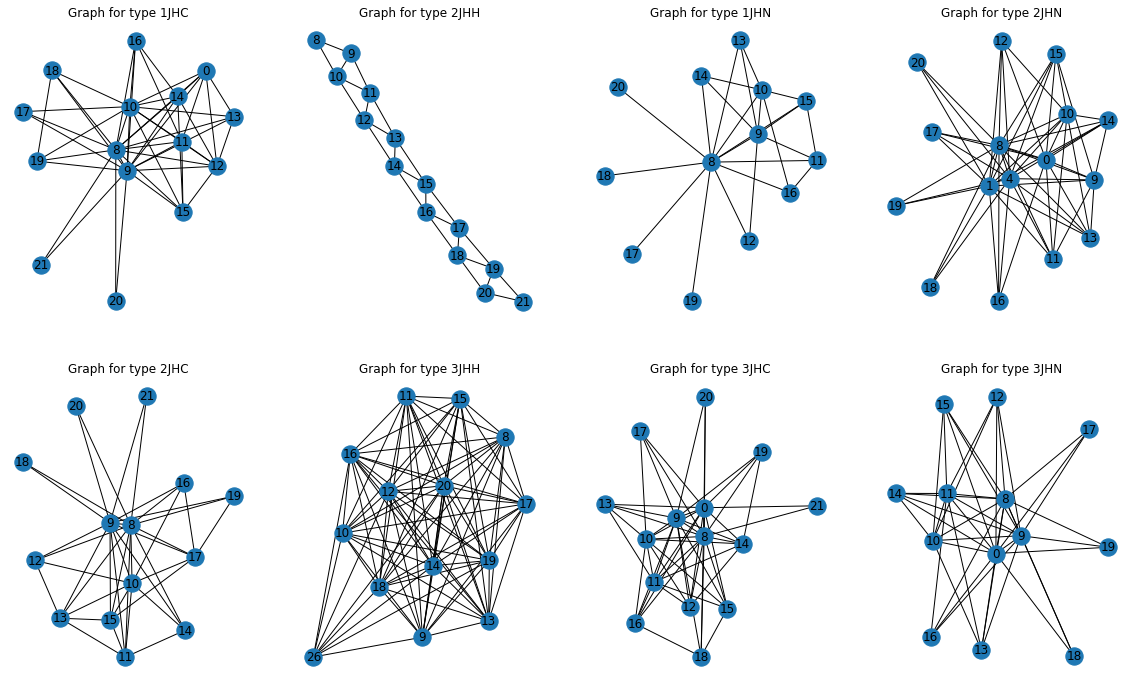

In [11]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_0) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Now the graphs are much more clear!

## Feature engineering

For now I'll use a basic approach to feature engineering.

I'll use this useful kernel:
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [12]:
structures = pd.read_csv('../data/structures.csv')

In [13]:
structures[:3]

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748


In [14]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [15]:
train[:3]

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152


In [16]:
test[:3]

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0


In [17]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

So, everyone uses this distance feature, let's have a look at it!

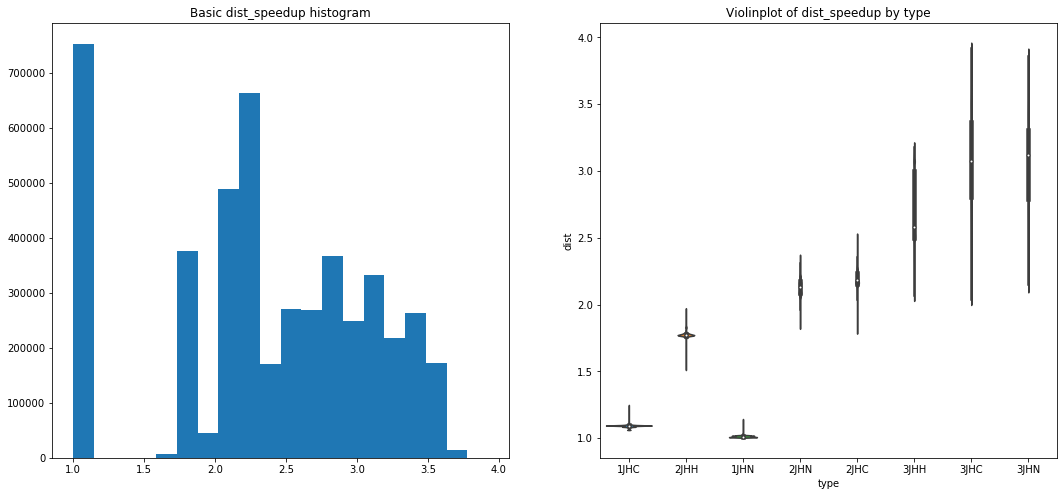

In [18]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist'], bins=20);
plt.title('Basic dist_speedup histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist', data=train);
plt.title('Violinplot of dist_speedup by type');

It seems that the values are quite different for different types!

In [19]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

## Basic model

I'll use the function for metric calculation from this kernel: https://www.kaggle.com/abhishek/competition-metric

In [20]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [21]:
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(train[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [22]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_to_type_mean
0,0,dsgdb9nsd_000001,1,0,0,84.807599999999994,0,0.002150416,-0.0060313176,0.0019761204,0,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,0.999133993514757
1,1,dsgdb9nsd_000001,1,2,3,-11.257000000000000,0,0.002150416,-0.0060313176,0.0019761204,1,1.0117308430,1.463751162,0.0002765748,1.783119756038801,1.004633785679569
2,2,dsgdb9nsd_000001,1,3,3,-11.254799999999999,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5408150690,1.447526614,-0.8766437152,1.783147496403011,1.004649414975929
3,3,dsgdb9nsd_000001,1,4,3,-11.254300000000001,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5238136345,1.437932644,0.9063972942,1.783156685329616,1.004654592141451
4,4,dsgdb9nsd_000001,2,0,0,84.807400000000001,0,1.011730843,1.4637511620,0.0002765748,0,-0.0126981359,1.085804158,0.0080009958,1.091951618581363,0.999132674975848


In [23]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

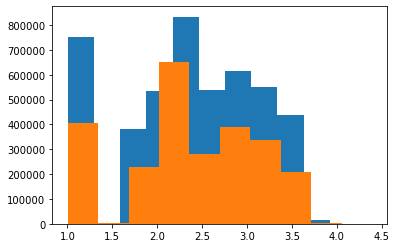

In [24]:
_ = plt.hist(train['dist'], label="train",)
_ = plt.hist(test['dist'], label="test")

In [25]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

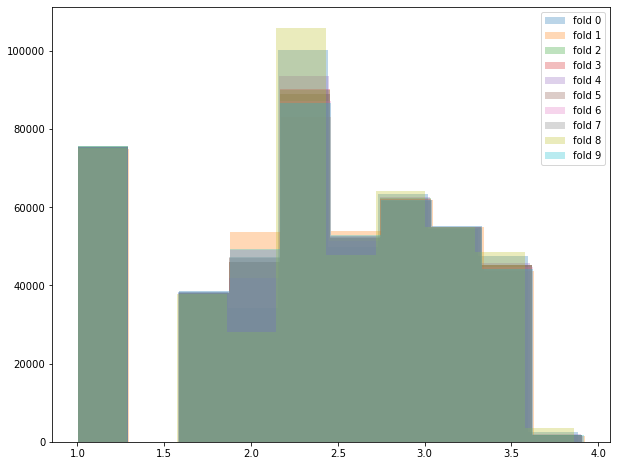

In [31]:
plt.figure(figsize=(10, 8))
for i, (train_idx, val_idx) in enumerate(folds.split(sorted_train)):
    _ = plt.hist(sorted_train.iloc[val_idx].dist, label=f'fold {i}', alpha=0.3)
    
plt.legend()

In [26]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.8,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0,
          'device' : 'gpu',
          'gpu_device_id': 1,
         }

print("training models...")
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test,
                                                      y=y,
                                                      params=params,
                                                      folds=folds,
                                                      model_type='lgb',
                                                      eval_metric='group_mae',
                                                      plot_feature_importance=True,
                                                      verbose=10,
                                                      early_stopping_rounds=200,
                                                      n_estimators=50)

training models...
Fold 1 started at Fri May 31 18:41:27 2019
Training until validation scores don't improve for 200 rounds.
[10]	training's l1: 2.30029	valid_1's l1: 2.30023
[20]	training's l1: 2.24446	valid_1's l1: 2.24793
[30]	training's l1: 2.20936	valid_1's l1: 2.21788
[40]	training's l1: 2.17932	valid_1's l1: 2.19226
[50]	training's l1: 2.15839	valid_1's l1: 2.17598
Did not meet early stopping. Best iteration is:
[50]	training's l1: 2.15839	valid_1's l1: 2.17598
current score 0.6425159531599958
Fold 2 started at Fri May 31 18:41:36 2019
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [21]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('submission.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,0.060426715059485
1,4658148,199.117008254897144
2,4658149,2.166049034856863
3,4658150,197.378324647927826
4,4658151,2.948001913907508


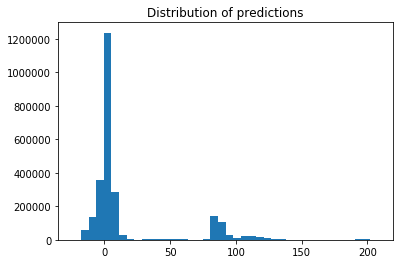

In [22]:
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');